# Usage

`liana` provides different statistical methods to infer `ligand-receptor` interactions from single-cell transcriptomics data omics data using prior knowledge.
In this notebook we showcase how to use liana in its' most basic form with toy data.

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting `SHIFT + TAB`, hit it twice to expand the view, or by typing `?name_of_function`.

</div>  

## Loading Packages

In [1]:
import liana as li

# Only needed for visualization:
import matplotlib.pyplot as plt
from scanpy.pl import umap

# toy data
from scanpy.datasets import pbmc68k_reduced
%matplotlib inline

## Loading toy data

`liana` uses `anndata` objects with processed single-cell (*and soon spatial*) transcriptomics data, with pre-defined cell labels (identities), to predict ligand-receptor interactions among all pairs of cell identities.

To load the example data-set, simply run:

In [2]:
adata = pbmc68k_reduced()

The example single-cell data consists processed data with PBMCs cell types

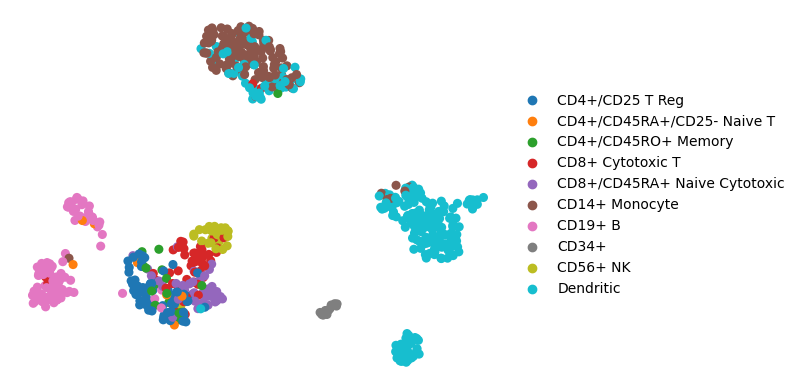

In [3]:
umap(adata, color='bulk_labels', title='', frameon=False)

## Background

In the most basic scenario, `liana` works with the log-trasformed counts matrix, in this object the normalized counts are stored in `raw`:

In [4]:
adata.raw.X

<700x765 sparse matrix of type '<class 'numpy.float32'>'
	with 174400 stored elements in Compressed Sparse Row format>

Preferably, one would use `liana` with all features (genes) for which we have enough counts, but for the sake of this tutorial we are working with a matrix pre-filtered to the variable features alone.

In the background, `liana` aggregates the counts matrix and generates statistics, typically related to cell identies.
These statistics are then utilized by each of the methods in `liana`.

### Methods

In [5]:
li.mt.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Kolde, R., Laur, S., Adler, P. and Vilo, J., 2..."
0,Geometric Mean,lr_gmeans,pvals,CellPhoneDBv2's permutation approach applied t...


Each method infers relevant ligand-receptor interactions relying on different assumptions and each method returns different ligand-receptor scores, typically a pair per method. One score corresponding to
the `magnitude` (strength) of interaction and the other reflecting how `specificity` of a given interaction to a pair cell identities.

<div class="alert alert-info">

**Note**
    
<h4> Method Class</h4>
    
Methods in liana are **callable** instances of the `Method` class. To obtain further information for each method the user can refer to the methods documentation `?method_name` or `?method.__call__`. Alternatively, users can use the `method.describe` function to get a short summary for each method.

</div>  


For example, if the user wishes to learn more about liana's `rank_aggregate` implementation, where we combine the scores of multiple methods, they could do the following: 

In [6]:
# import liana's rank_aggregate
from liana.mt import rank_aggregate

In [7]:
?rank_aggregate.__call__

Signature:
rank_aggregate.__call__(
    adata: anndata._core.anndata.AnnData,
    groupby: str,
    resource_name: str = 'consensus',
    expr_prop: float = 0.1,
    min_cells: int = 5,
    base: float = 2.718281828459045,
    aggregate_method='rra',
    consensus_opts=None,
    use_raw: Union[bool, NoneType] = True,
    layer: Union[str, NoneType] = None,
    de_method='t-test',
    verbose: Union[bool, NoneType] = False,
    n_perms: int = 1000,
    seed: int = 1337,
    resource: Union[pandas.core.frame.DataFrame, NoneType] = None,
    inplace=True,
)
Docstring:
Parameters
----------
adata
    Annotated data object.
groupby
    The key of the observations grouping to consider.
resource_name
    Name of the resource to be loaded and use for ligand-receptor inference.
expr_prop
    Minimum expression proportion for the ligands/receptors (and their subunits) in the
     corresponding cell identities. Set to `0`, to return unfiltered results.
min_cells
    Minimum cells per cell identit

or alternatively:

In [8]:
rank_aggregate.describe()

Rank_Aggregate returns `magnitude_rank`, `specificity_rank`, and `steady_rank`. magnitude_rank and specificity_rank represent an aggregate of the `magnitude`- and `specificity`-related scoring functions from the different methods.steady_rank represents one scoring function from each method intended to prioritize ligand-receptor interactions in steady-state data, regardless if they represent `specificity` or `magnitude`.


#### Resources

To provide ligand-receptor predictions `liana` relies on prior-knowledge and makes use of the following ligand-receptor resources:

In [9]:
li.resource.show_resources()

['baccin2019',
 'cellcall',
 'cellchatdb',
 'cellinker',
 'cellphonedb',
 'celltalkdb',
 'connectomedb2020',
 'consensus',
 'embrace',
 'guide2pharma',
 'hpmr',
 'icellnet',
 'italk',
 'kirouac2010',
 'lrdb',
 'mouseconsensus',
 'ramilowski2015']

These were pre-generated using the [OmniPath](https://github.com/saezlab/omnipath) meta-database, but any custom resource can also be passed.
We refer the user to [OmniPath](https://github.com/saezlab/omnipath) as a useful tool to build any resource.

    
By default, `liana` uses the `consensus` resource, which is composed by multiple expert-curated ligand-receptor resources, including CellPhoneDB, CellChat, ICELLNET, connectomeDB2020, and CellTalkDB.


## Example Run

### Individual Methods

In [10]:
# import individual methods
from liana.mt import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat

<div class="alert alert-info">

**Note**

LIANA will by default use the `.raw` attribute of AnnData. If you wish to use .X set `use_raw` to `False`, or specify a `layer`.
    
    
</div>  

In [11]:
# run cellphonedb
cellphonedb(adata, groupby='bulk_labels', expr_prop=0.1, verbose=True)

Using `.raw`!
0.94 of entities in the resource are missing from the data
Generating ligand-receptor stats for 700 samples and 765 features


100%|██████████| 1000/1000 [00:03<00:00, 279.06it/s]


By default, liana will be run **inplace** and results will be assigned to `adata.uns['liana_res']`.
Note that the high proportion of missing entities here is expected, as we are working on the reduced dimensions data.

In [12]:
# by default, liana's output is saved in place:
adata.uns['liana_res'].head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,pvals
0,HLA-DRA,HLA-DRA,0.625279,0.323529,CD4,CD4,0.295691,0.220588,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.460485,1.0
1,HLA-DQA2,HLA-DQA2,0.196956,0.117647,CD4,CD4,0.295691,0.220588,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.246324,1.0
2,HLA-DQA1,HLA-DQA1,0.253897,0.161765,CD4,CD4,0.295691,0.220588,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.274794,1.0
3,HLA-DRB1,HLA-DRB1,0.853603,0.382353,CD4,CD4,0.295691,0.220588,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.574647,1.0
4,HLA-DQB1,HLA-DQB1,0.401779,0.279412,CD4,CD4,0.295691,0.220588,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.348735,1.0


Here, we see that generic stats are provided for both `ligand` and `receptor` *entities*, more specifically:
- `ligand` and `receptor` are typically the two entities that interact. Though it should be noted that these are not limited to secreted signalling. Also, in the case of heteromeric complexes, these represent the subunit with minimum expression, while `*_complex` corresponds to the actual complex, and is hence the unique key for each row. 

- `source` and `target` columns represent the `source/sender` and `target/receiver` cell identity for each interaction, respectively

- `*_props`: represents the proportion of cells that express the entity

- `*_pvals`: 1vsRest p-value calculated at the single-cell level

- `*_means`: entity expression mean per cell type

- `lr_means`: mean ligand-receptor expression, as a measure of ligand-receptor interaction *magnitude*

- `pvals`: permutation-based p-value, as a measure of interaction *specificity*

Note that `ligand`, `receptor`, `source`, `target` columns are returned by every method, while the rest can vary across the methods.

#### Dotplot

We can now visualize the results that we just obtained.

LIANA provides some basic, but flexible plotting functionalities. Here, we will generate a dotplot of relevant ligand-receptor interactions.

In [13]:
my_p = li.pl.dotplot(adata = adata, 
                     colour='lr_means',
                     size='pvals',
                     inverse_size=True, # we inverse sign since we want small p-values to have large sizes
                     source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
                     target_labels=['CD34+', 'CD56+ NK'],
                     figure_size=(8, 7),
                     # finally, since cpdbv2 suggests using a filter to FPs
                     # we filter the pvals column to <= 0.05
                     filterby='pvals',
                     filter_lambda=lambda x: x <= 0.05
                    )

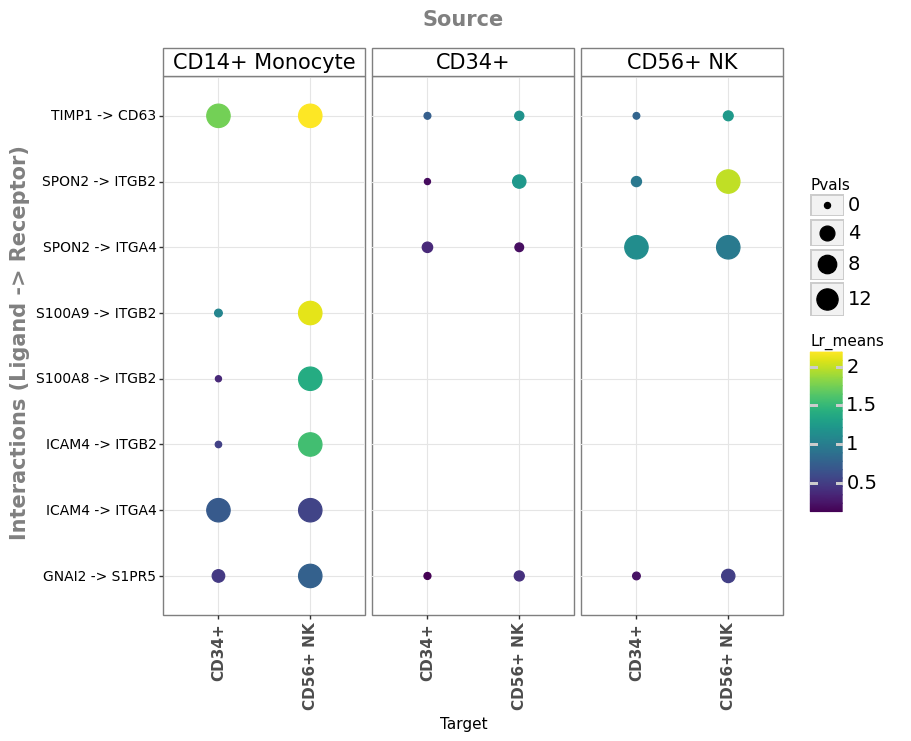

<ggplot: (8745950281409)>

In [14]:
my_p

<div class="alert alert-info">
   
**Note**
    
Missing dots here would represent interactions for which the ligand and receptor are not expressed above the `expr_prop`.
</div>

### Rank Aggregate
In addition to the individual methods, LIANA also provides a consensus that integrates the predictions of individual methods.
This is done by ranking and aggregating ([RRA](https://academic.oup.com/bioinformatics/article-abstract/28/4/573/213339)) the ligand-receptor interaction predictions from all methods.

In [15]:
# Run rank_aggregate
li.mt.rank_aggregate(adata, groupby='bulk_labels', expr_prop=0.1, verbose=True)

Using `.raw`!
0.94 of entities in the resource are missing from the data
Generating ligand-receptor stats for 700 samples and 765 features
Assuming that counts were `natural` log-normalized!


  4%|▎         | 35/1000 [00:00<00:02, 348.41it/s]

Running CellPhoneDB


100%|██████████| 1000/1000 [00:02<00:00, 335.92it/s]


Running Connectome
Running log2FC
Running NATMI


  0%|          | 0/1000 [00:00<?, ?it/s]

Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [00:02<00:00, 342.22it/s]


In [16]:
adata.uns['liana_res'].head()

,source,target,ligand_complex,receptor_complex,lr_means,pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,magnitude_rank,specificity_rank,steady_rank
1106,CD56+ NK,CD56+ NK,SPON2,ITGB2,1.948322,0.0,3.710696,1.867642,1.860055,0.121435,0.763774,0.160759,0.0,0.000649,0.000185,0.000004
898,CD56+ NK,CD14+ Monocyte,SPON2,ITGB2,1.873937,0.0,3.464283,1.789787,1.860121,0.113371,0.757519,0.151997,0.0,0.001268,0.000185,0.000007
967,CD19+ B,CD19+ B,LTB,CD40,1.634168,0.0,1.314091,0.699518,1.128614,0.079295,0.658011,0.044889,0.0,0.032016,0.000185,0.000029
589,CD56+ NK,CD8+ Cytotoxic T,SPON2,ITGB2,1.466578,0.0,2.114848,1.363432,1.214773,0.069210,0.709378,0.094773,0.0,0.017027,0.000185,0.000029
1261,CD56+ NK,Dendritic,SPON2,ITGB2,1.714034,0.0,2.934582,1.622428,1.578404,0.096036,0.741955,0.135729,0.0,0.001653,0.000185,0.000029


In [17]:
rank_aggregate.describe()

Rank_Aggregate returns `magnitude_rank`, `specificity_rank`, and `steady_rank`. magnitude_rank and specificity_rank represent an aggregate of the `magnitude`- and `specificity`-related scoring functions from the different methods.steady_rank represents one scoring function from each method intended to prioritize ligand-receptor interactions in steady-state data, regardless if they represent `specificity` or `magnitude`.


The remainder of the columns in this dataframe are those coming from each of the methods included in the `rank_aggregate` - i.e. see the `show_methods` to map methods to scores.

#### Dotplot

We will now plot the most 'relevant' interactions ordered to the `steady_rank` results from aggregated_rank.

In [18]:
my_p = li.pl.dotplot(adata = adata, 
                     colour='lrscore',
                     size='specificity_rank',
                     inverse_size=True,
                     source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
                     target_labels=['CD34+', 'CD56+ NK'],
                     top_n=20, 
                     orderby='steady_rank',
                     orderby_ascending=True,
                     figure_size=(8, 7)
                    )

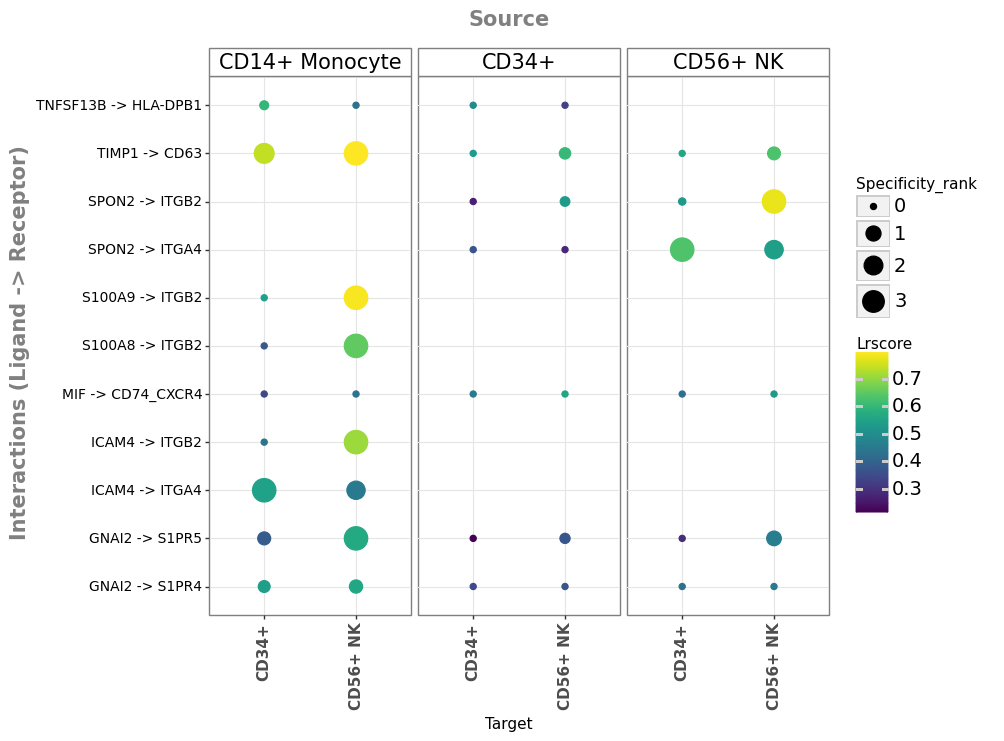

<ggplot: (8745953640623)>

In [19]:
my_p

Similarly, we can also treat the ranks provided by RRA as a probability distribution to which we can filter interactions
according to how robustly and highly ranked they are across the different methods.

In [20]:
my_p = li.pl.dotplot(adata = adata, 
                     colour='lrscore',
                     size='specificity_rank',
                     inverse_size=True,
                     source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
                     target_labels=['CD34+', 'CD56+ NK'],
                     filterby='steady_rank',
                     filter_lambda=lambda x: x <= 0.01,
                    )

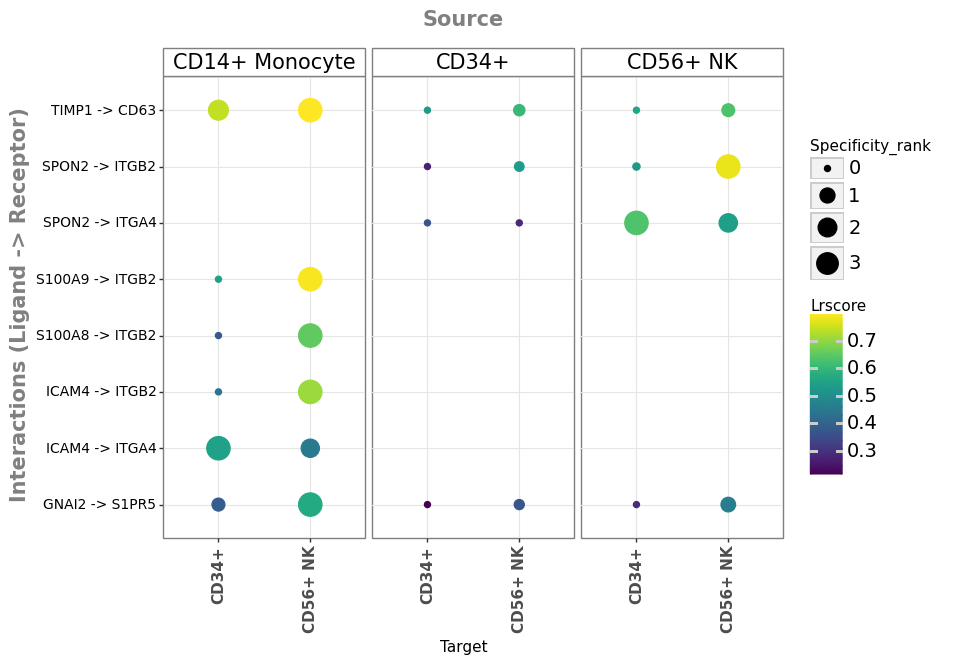

<ggplot: (8745945337022)>

In [21]:
my_p

Finally, the plots in liana are built with `plotnine` and their aesthetics can be easily modified. For example:

In [22]:
# we import plotnine
import plotnine as p9

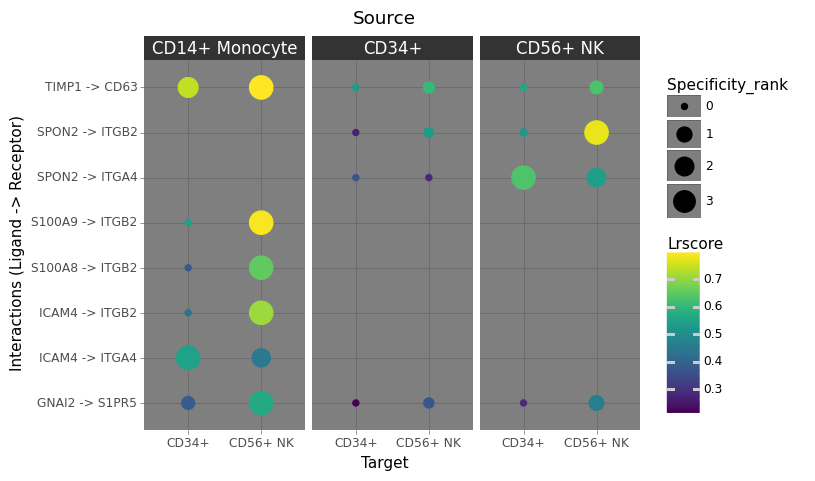

<ggplot: (8745951488717)>

In [23]:
(my_p +
 # change theme
 p9.theme_dark() +
 # modify theme
 p9.theme(
     # adjust facet size
     strip_text=p9.element_text(size=12)
 )
)

For more plot modification options  we refer the user to `plotnine`'s tutorials
and to the following link for a quick intro: 
https://datacarpentry.org/python-ecology-lesson/07-visualization-ggplot-python/index.html.